In [1]:
from dist_tools import *

%matplotlib inline

In [2]:
pd.options.display.max_rows = 10000

In [3]:
fips, epsg, seats = 48, 3665, 36

In [4]:
tx_co = pd.read_sql("SELECT county, name FROM counties_2016 WHERE state = 48 ORDER BY county;",
                    con = psycopg2.connect(database = "census", user = user, password = passwd,
                                           host = "saxon.harris.uchicago.edu", port = 5432))
tx_co = list(tx_co.county)

In [5]:
pr_tr_query = """SELECT
                   tr.state, tr.county cid,
                   REGEXP_REPLACE(UPPER(pr.name), '^0+', '') AS vtd,
                   -- pr.geoid, tr.tract, 
                   rn.rn
                 FROM census_tracts_2015 AS tr
                 JOIN vtd_2010 AS pr ON
                   pr.state  = tr.state  AND
                   pr.county = tr.county AND
                   ST_Covers(tr.geom, ST_Centroid(pr.geom))
                 JOIN (SELECT state, county, tract,
                              row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                       FROM census_tracts_2015) rn ON
                   tr.state  = rn.state  AND
                   tr.county = rn.county AND
                   tr.tract  = rn.tract
                 JOIN counties_2016 co ON
                   tr.state  = co.state AND
                   tr.county = co.county
                 WHERE tr.state = 48
                 ORDER BY tr.state, tr.county, tr.tract, pr.vtd;"""

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

# trprdf = pd.read_sql(pr_tr_query.format(fips), con)
# trprdf.to_csv("tx_trpr.csv", index = False)

trprdf = pd.read_csv("tx_trpr.csv")

In [6]:
votes = {}
for y in [1996, 2000, 2004, 2008]:
    
    yv = "{:02d}".format(y % 100)

    votes[y] = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/TX_%d.tab" % y, sep = "\t")\
                 .sort_values(by = ["county", "vtd"])\
                 .rename(columns = {"fips" : "cid", "vtd" : "vtd_tx", 
                                    "g{}_USP_dv".format(y) : "D" + yv, 
                                    "g{}_USP_rv".format(y) : "R" + yv})\
                 [["cid", "county", "vtd_tx", "D" + yv, "R" + yv]]
    votes[y].vtd_tx = votes[y].vtd_tx.str.replace(r'^0+', r'') # improve match rate....

    votes[y]['vtd'] = "NOMATCH"

    for cid in tx_co:
        votes[y].loc[votes[y].cid == cid, 'vtd'] = \
            votes[y][votes[y].cid == cid]['vtd_tx'].\
                apply(lambda x: jf_jw_match(x, trprdf[trprdf.cid == cid]["vtd"])[0])

    votes[y].loc[votes[y].vtd_tx != votes[y].vtd, "vtd_tx"] = \
        votes[y][votes[y].vtd_tx != votes[y].vtd].vtd_tx.str.replace(r'[ABC]$', r'')
        
    for cid in tx_co:
        votes[y].loc[votes[y].cid == cid, 'vtd'] = \
            votes[y][votes[y].cid == cid]['vtd_tx'].\
                apply(lambda x: jf_jw_match(x, trprdf[trprdf.cid == cid]["vtd"])[0])
    
    votes[y] = votes[y].merge(trprdf, on = ["cid", "vtd"])[['cid', 'county', 'vtd', 'D' + yv, 'R' + yv, 'rn']]
    votes[y] = votes[y].groupby("rn").sum()[['D' + yv, 'R' + yv]]

In [7]:
tx_tr = gpd.GeoDataFrame.from_postgis("""SELECT
                                           rn.rn, ST_Transform(tr.geom, epsg) geometry
                                         FROM census_tracts_2015 AS tr
                                         JOIN (SELECT state, county, tract,
                                                      row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                                               FROM census_tracts_2015) rn ON
                                           tr.state  = rn.state  AND
                                           tr.county = rn.county AND
                                           tr.tract  = rn.tract
                                         JOIN states st ON
                                           tr.state  = st.fips
                                         WHERE tr.state = 48
                                         ORDER BY rn;
                                      """,
                                      geom_col = "geometry", crs = from_epsg(epsg),
                                      con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                             host = "saxon.harris.uchicago.edu", port = 5432))

tx_state_shp = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/tx_site/tx_vtd_2016/VTDs.shp")
tx_state_shp = tx_state_shp[['CNTY', 'VTD', 'geometry']].rename(columns = {"CNTY" : "cid", "VTD" : "vtd"})
tx_state_shp.vtd = tx_state_shp.vtd.str.replace(r'^0+', r'') # improve match rate....
tx_state_shp.geometry = tx_state_shp.geometry.centroid
tx_state_shp = tx_state_shp.sort_values(by = ["cid", "vtd"]).reset_index()[["cid", "vtd", "geometry"]]
tx_state_shp = tx_state_shp.to_crs(epsg = epsg)

tx_tr_shp = gpd.sjoin(tx_state_shp, tx_tr, op = "within")[["rn", "cid", "vtd"]]

Finally, we're doing an attribute join to join the (geo-matched) tract/precincts to the votes, on the VTD key.

In [8]:
for y in [2012, 2016]:
    yv = "{:02d}".format(y%100)
    votes[y] = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/tx_site/tx_%d.csv" % y, sep = ",")\
                 .sort_values(by = ["County", "VTD"])\
                 .rename(columns = {"FIPS" : "cid", "VTD" : "vtd", "County" : "county"})
            
    votes[y] = votes[y][votes[y].Votes > 0]
    votes[y] = votes[y][["cid", "county", "vtd", "Party", "Votes"]] # D" + yv, "R" + yv]]
    votes[y].vtd = votes[y].vtd.str.replace(r'^0+', r'') # improve match rate....
    votes[y].Party += yv
    
    votes[y] = pd.pivot_table(votes[y], values = "Votes", index = ["county", "cid", "vtd"], columns = ["Party"])
    votes[y] = votes[y].fillna(0).astype(int).reset_index()[["cid", "county", "vtd", "D" + yv, "R" + yv]]
    
    votes[y].cid = votes[y].cid.astype(int)
    
    votes[y] = pd.merge(tx_tr_shp, votes[y], on = ["cid", "vtd"])
    
    votes[y] = votes[y].groupby("rn").sum()[['D' + yv, 'R' + yv]]

In [9]:
tx_tr_votes = pd.concat([votes[y] for y in [1996, 2000, 2004, 2008, 2012, 2016]], axis = 1).sort_index()
tx_tr_votes = tx_tr_votes[(tx_tr_votes.columns)].fillna(0).astype(int)
tx_tr_votes = tx_tr.set_index("rn").join(tx_tr_votes)

for y in [1996, 2000, 2004, 2008, 2012, 2016]:
    yv = "{:02d}".format(y%100)
    tx_tr_votes["%d D Fr" % y] = tx_tr_votes["D" + yv] / (tx_tr_votes["D" + yv] + tx_tr_votes["R" + yv]) 

tx_tr_votes.to_file("tx_tr_votes.shp")
tx_tr_votes.fillna(0).filter(regex = '[RD][0-9]+', axis = 1).to_csv("tx_votes.csv")

In [10]:
pd.read_csv("tx_votes.csv", index_col = "rn")

,D96,R96,D00,R00,D04,R04,D08,R08,D12,R12,D16,R16
rn,,,,,,,,,,,,
0,728.0,883.0,715.0,1480.0,661.0,1710.0,564.0,1881.0,489.0,1872.0,382.0,2162.0
1,59.0,97.0,77.0,214.0,128.0,243.0,52.0,274.0,40.0,268.0,36.0,280.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,511.0,551.0,433.0,798.0,403.0,920.0,425.0,855.0,541.0,1280.0,490.0,1245.0
4,1121.0,773.0,989.0,1120.0,861.0,1226.0,881.0,1171.0,792.0,1095.0,701.0,1061.0
5,392.0,76.0,363.0,123.0,300.0,215.0,463.0,228.0,377.0,309.0,313.0,346.0
6,690.0,1142.0,565.0,1440.0,523.0,1516.0,527.0,1343.0,264.0,721.0,248.0,726.0
7,411.0,579.0,397.0,922.0,386.0,1235.0,401.0,1367.0,324.0,1380.0,283.0,1494.0
8,526.0,728.0,474.0,1143.0,433.0,1339.0,393.0,1422.0,365.0,1353.0,292.0,1472.0


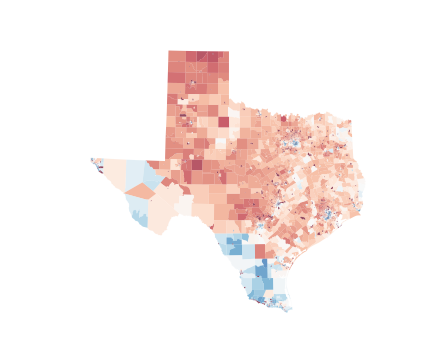

In [10]:
# ax = tx_tr_votes.plot(column = "2000 D Fr", cmap = "RdBu", linewidth = 0, alpha = 0.7, k = 9)
# ax.set_axis_off()